# Iterative Ensemble Smoother (IES) and Ensemble Smoother with Multiple Data Assimilation (ES-MDA) with the Burgers PDE

Using IES and ES-MDA to estimate fluid viscosity.

In [5]:
import matplotlib.pyplot as plt

import numpy as np

rng = np.random.default_rng(12345)

import pandas as pd

from p_tqdm import p_map
from ipywidgets import interact
import ipywidgets as widgets

from iterative_ensemble_smoother import IterativeEnsembleSmoother

In [6]:
%load_ext autoreload
%autoreload 2
from dass import pde, utils, analysis, taper

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Define true parameter and run forward model, i.e., Burgers' equation.

In [7]:
nx = 41
ny = 41

# time steps
k_start = 0
k_end = 500

nu_true = 0.1
u = pde.burgers(nx=nx, ny=ny, nt=k_end, nu=nu_true)

In [8]:
def interactive_truth(k):
    fig, ax = plt.subplots()
    fig.suptitle("True response")
    p = ax.pcolormesh(u[k])
    ax.set_title(f"k = {k}")
    utils.colorbar(p)
    fig.tight_layout()


interact(
    interactive_truth,
    k=widgets.IntSlider(min=k_start, max=k_end - 1, step=1, value=0),
)

interactive(children=(IntSlider(value=0, description='k', max=499), Output()), _dom_classes=('widget-interact'…

<function __main__.interactive_truth(k)>

## Define placement of sensors and generate synthetic observations based on the true field values

Number of observations:  4000


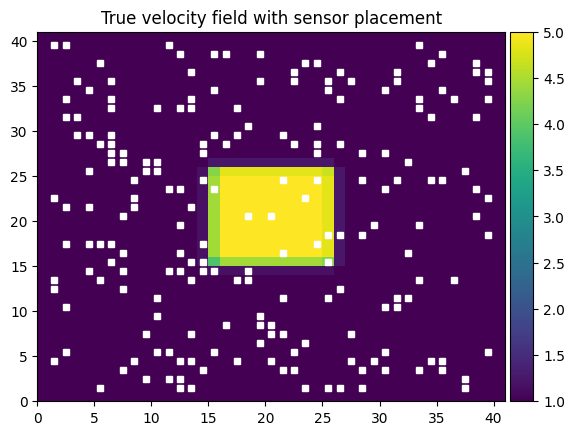

In [9]:
# placement of sensors, i.e, where the observations are done
pad = 1
coords = np.array([(x, y) for x in range(pad, nx - pad) for y in range(pad, nx - pad)])
ncoords = coords.shape[0]
nmeas = 200
coords_idx = np.random.choice(np.arange(ncoords), size=nmeas, replace=False)
obs_coordinates = [utils.Coordinate(xc, yc) for xc, yc in coords[coords_idx]]

# At which times observations are taken
obs_times = np.linspace(5, k_end, 20, endpoint=False, dtype=int)

d = utils.observations(obs_coordinates, obs_times, u, lambda value: abs(0.01 * value))
# number of measurements
m = d.shape[0]
print("Number of observations: ", m)

# Plot temperature field and show placement of sensors.
obs_coordinates = set(zip(d.index.get_level_values("x"), d.index.get_level_values("y")))
x, y = zip(*obs_coordinates)

fig, ax = plt.subplots()
p = ax.pcolormesh(u[0], cmap=plt.cm.viridis)
ax.set_title("True velocity field with sensor placement")
utils.colorbar(p)
ax.plot([i + 0.5 for i in x], [j + 0.5 for j in y], "s", color="white", markersize=5)

In [10]:
# Number of realisations
N = 50

In [11]:
ss = np.random.SeedSequence(12345)
child_seeds = ss.spawn(N)
streams = [np.random.default_rng(s) for s in child_seeds]

In [12]:
# List of matrices of size (nx, nx) containing priors.
# The reason for having a list is that `p_map` requires it.
# `p_map` runs stuff in parallel.
A_IES = rng.uniform(low=0.0, high=0.6, size=N)

(array([1., 0., 3., 1., 1., 2., 1., 2., 4., 1., 5., 1., 1., 1., 2., 1., 0.,
        1., 3., 1., 1., 3., 2., 1., 0., 2., 0., 2., 2., 5.]),
 array([0.0030134 , 0.02189058, 0.04076775, 0.05964493, 0.07852211,
        0.09739928, 0.11627646, 0.13515363, 0.15403081, 0.17290799,
        0.19178516, 0.21066234, 0.22953952, 0.24841669, 0.26729387,
        0.28617105, 0.30504822, 0.3239254 , 0.34280257, 0.36167975,
        0.38055693, 0.3994341 , 0.41831128, 0.43718846, 0.45606563,
        0.47494281, 0.49381999, 0.51269716, 0.53157434, 0.55045151,
        0.56932869]),
 <BarContainer object of 30 artists>)

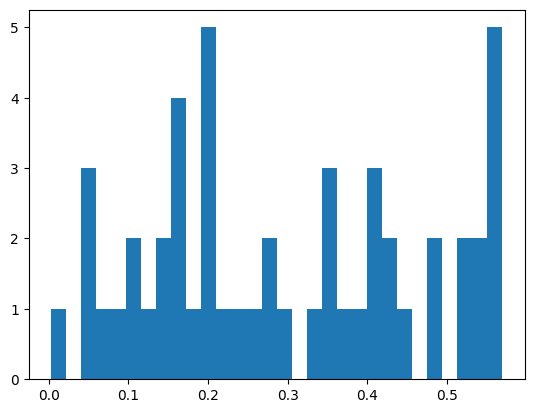

In [13]:
fig, ax = plt.subplots()
ax.hist(A_IES, bins=30)

In [14]:
def get_steplength(iteration_nr: int) -> float:
    """
    This is an implementation of Eq. (49), which calculates a suitable step length for
    the update step, from the book:

    Geir Evensen, Formulating the history matching problem with consistent error statistics,
    Computational Geosciences (2021) 25:945 –970
    """
    max_steplength: float = 0.6
    min_steplength: float = 0.3
    dec_steplength: float = 2.5

    steplength = min_steplength + (max_steplength - min_steplength) * pow(
        2, -(iteration_nr - 1) / (dec_steplength - 1)
    )
    return steplength

In [15]:
number_of_ies_iterations = 3

# Coefficient matrix as defined in Eq. 16 and Eq. 17.
W = np.zeros(shape=(N, N))

# Use same prior for all methods.
A_IES_ert = A_IES.copy()
A_ESMDA = A_IES.copy()

In [16]:
df_IES = pd.DataFrame({"Iteration": [0] * len(A_IES), "Value": A_IES})
df_IES_ert = pd.DataFrame({"Iteration": [0] * len(A_IES_ert), "Value": A_IES_ert})
df_ESMDA = pd.DataFrame({"Iteration": [0] * len(A_ESMDA), "Value": A_ESMDA})

## Running ES for reference

In [17]:
A_ES = A_IES.copy()

fwd_runs = p_map(
    pde.burgers,
    [nx] * N,
    [ny] * N,
    [k_end] * N,
    A_ES,
    desc=f"Running forward model.",
)

# Assume diagonal ensemble covariance matrix for the measurement perturbations.
Cdd = np.diag(d.sd.values**2)

# 9.4 Ensemble representation for measurements
E = rng.multivariate_normal(mean=np.zeros(len(Cdd)), cov=Cdd, size=N).T
E = E - E.mean(axis=1, keepdims=True)
assert E.shape == (m, N)

D = np.ones((m, N)) * d.value.values.reshape(-1, 1) + E

Y = np.array(
    [
        fwd_run[
            d.index.get_level_values("k").to_list(),
            d.index.get_level_values("y").to_list(),
            d.index.get_level_values("x").to_list(),
        ]
        for fwd_run in fwd_runs
    ]
).T

# We expect that a certain number of points gets deactivated,
# since not all cells are changing values due to the way the model works.
enough_ens_var_idx = Y.var(axis=1) > 1e-6
print(f"{list(enough_ens_var_idx).count(False)} measurements will be deactivated.")
Y = Y[enough_ens_var_idx, :]
D = D[enough_ens_var_idx, :]
Cdd = Cdd[enough_ens_var_idx, :]
Cdd = Cdd[:, enough_ens_var_idx]

X = analysis.ES(Y, D, Cdd)
A_ES = A_ES @ X

Running forward model.:   0%|          | 0/50 [00:00<?, ?it/s]

339 measurements will be deactivated.


## Running `dass`'s implementation of IES

In [18]:
for i in range(number_of_ies_iterations):

    # Step length in Gauss Newton
    gamma = get_steplength(i)

    fwd_runs = p_map(
        pde.burgers,
        [nx] * N,
        [ny] * N,
        [k_end] * N,
        A_IES,
        desc=f"Running forward model.",
    )

    # Assume diagonal ensemble covariance matrix for the measurement perturbations.
    Cdd = np.diag(d.sd.values**2)

    # 9.4 Ensemble representation for measurements
    E = rng.multivariate_normal(mean=np.zeros(len(Cdd)), cov=Cdd, size=N).T
    E = E - E.mean(axis=1, keepdims=True)
    assert E.shape == (m, N)

    D = np.ones((m, N)) * d.value.values.reshape(-1, 1) + E

    Y = np.array(
        [
            fwd_run[
                d.index.get_level_values("k").to_list(),
                d.index.get_level_values("y").to_list(),
                d.index.get_level_values("x").to_list(),
            ]
            for fwd_run in fwd_runs
        ]
    ).T

    assert Y.shape == (
        m,
        N,
    ), "Measured responses must be a matrix with dimensions (number of observations x number of realisations)"

    # We expect that a certain number of points gets deactivated,
    # since not all cells are changing values due to the way the model works.
    enough_ens_var_idx = Y.var(axis=1) > 1e-6
    print(f"{list(enough_ens_var_idx).count(False)} measurements will be deactivated.")
    Y = Y[enough_ens_var_idx, :]
    D = D[enough_ens_var_idx, :]
    Cdd = Cdd[enough_ens_var_idx, :]
    Cdd = Cdd[:, enough_ens_var_idx]

    W = analysis.IES(Y, D, Cdd, W, gamma)
    X_IES = np.identity(N) + W
    A_IES = A_IES @ X_IES

    df_iter = pd.DataFrame({"Iteration": [i + 1] * len(A_IES), "Value": A_IES})
    df_IES = pd.concat([df_IES, df_iter])

Running forward model.:   0%|          | 0/50 [00:00<?, ?it/s]

339 measurements will be deactivated.


Running forward model.:   0%|          | 0/50 [00:00<?, ?it/s]

999 measurements will be deactivated.


Running forward model.:   0%|          | 0/50 [00:00<?, ?it/s]

2348 measurements will be deactivated.


In [19]:
df_IES_pivot = df_IES.pivot(columns="Iteration", values="Value")
df_IES_pivot.columns.name = ""
df_IES_pivot.columns = ["Value_" + str(s) for s in df_IES_pivot.columns]

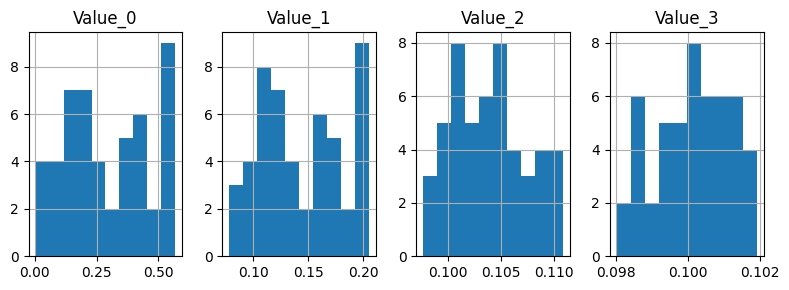

In [20]:
fig, ax = plt.subplots(1, number_of_ies_iterations + 1)
fig.set_size_inches(8, 3)
df_IES_pivot.hist(ax=ax)
fig.tight_layout()

## Running ERT's implementation of IES

In [21]:
for i in range(number_of_ies_iterations):

    # Step length in Gauss Newton
    gamma = get_steplength(i)

    fwd_runs = p_map(
        pde.burgers,
        [nx] * N,
        [ny] * N,
        [k_end] * N,
        A_IES_ert.ravel(),
        desc=f"Running forward model.",
    )

    Y = np.array(
        [
            fwd_run[
                d.index.get_level_values("k").to_list(),
                d.index.get_level_values("y").to_list(),
                d.index.get_level_values("x").to_list(),
            ]
            for fwd_run in fwd_runs
        ]
    ).T

    assert Y.shape == (
        m,
        N,
    ), "Measured responses must be a matrix with dimensions (number of observations x number of realisations)"

    # We expect that a certain number of points gets deactivated,
    # since not all cells are changing values due to the way the model works.
    enough_ens_var_idx = Y.var(axis=1) > 1e-6
    print(f"{list(enough_ens_var_idx).count(False)} measurements will be deactivated.")
    Y = Y[enough_ens_var_idx, :]

    A_IES_ert = IterativeEnsembleSmoother(N).update_step(
        Y,
        A_IES_ert.reshape(1, -1),
        d.sd.values[enough_ens_var_idx],
        d.value.values[enough_ens_var_idx],
        step_length=gamma,
    )

    df_iter = pd.DataFrame(
        {"Iteration": [i + 1] * len(A_IES_ert.ravel()), "Value": A_IES_ert.ravel()}
    )
    df_IES_ert = pd.concat([df_IES_ert, df_iter])

Running forward model.:   0%|          | 0/50 [00:00<?, ?it/s]

339 measurements will be deactivated.


Running forward model.:   0%|          | 0/50 [00:00<?, ?it/s]

942 measurements will be deactivated.


Running forward model.:   0%|          | 0/50 [00:00<?, ?it/s]

1428 measurements will be deactivated.


In [22]:
df_IES_ert_pivot = df_IES_ert.pivot(columns="Iteration", values="Value")
df_IES_ert_pivot.columns.name = ""
df_IES_ert_pivot.columns = ["Value_" + str(s) for s in df_IES_ert_pivot.columns]

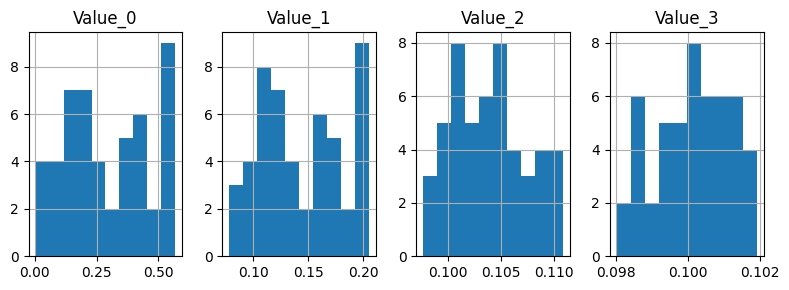

In [23]:
fig, ax = plt.subplots(1, number_of_ies_iterations + 1)
fig.set_size_inches(8, 3)
df_IES_pivot.hist(ax=ax)
fig.tight_layout()

##  Ensemble Smoother with Multiple Data Assimilation (ES-MDA)

In [24]:
weights = [4, 2, 1]

In [25]:
# Same function is used in ERT.
from typing import List


def normalize_weights(weights: List[float]) -> List[float]:
    """Scale weights such that their reciprocals sum to 1.0,
    i.e., sum(1.0 / x for x in weights) == 1.0.
    See for example Equation 38 of evensen2018 - Analysis of iterative
    ensemble smoothers for solving inverse problems.
    """
    if not weights:
        return []
    weights = [weight for weight in weights if abs(weight) != 0.0]

    length = sum(1.0 / x for x in weights)
    return [x * length for x in weights]

In [26]:
normalized_weights = normalize_weights(weights)

In [27]:
for i, w in enumerate(normalized_weights):
    fwd_runs = p_map(
        pde.burgers,
        [nx] * N,
        [ny] * N,
        [k_end] * N,
        A_ESMDA,
        desc=f"Running forward model.",
    )

    # Assume diagonal ensemble covariance matrix for the measurement perturbations.
    # Inflating measurement errors by a factor sqrt(normalized_weights) as shown
    # in for example evensen2018 - Analysis of iterative ensemble smoothers for solving inverse problems.
    Cdd = np.diag((d.sd.values * np.sqrt(w)) ** 2)

    # 9.4 Ensemble representation for measurements
    E = rng.multivariate_normal(mean=np.zeros(len(Cdd)), cov=Cdd, size=N).T
    E = E - E.mean(axis=1, keepdims=True)
    assert E.shape == (m, N)

    D = np.ones((m, N)) * d.value.values.reshape(-1, 1) + E

    Y = np.array(
        [
            fwd_run[
                d.index.get_level_values("k").to_list(),
                d.index.get_level_values("y").to_list(),
                d.index.get_level_values("x").to_list(),
            ]
            for fwd_run in fwd_runs
        ]
    ).T

    assert Y.shape == (
        m,
        N,
    ), "Measured responses must be a matrix with dimensions (number of observations x number of realisations)"

    # We expect that a certain number of points gets deactivated,
    # since not all cells are changing values due to the way the model works.
    enough_ens_var_idx = Y.var(axis=1) > 1e-6
    print(f"{list(enough_ens_var_idx).count(False)} measurements will be deactivated.")
    Y = Y[enough_ens_var_idx, :]
    D = D[enough_ens_var_idx, :]
    Cdd = Cdd[enough_ens_var_idx, :]
    Cdd = Cdd[:, enough_ens_var_idx]

    X_ESMDA = analysis.ES(Y, D, Cdd)
    A_ESMDA = A_ESMDA @ X_ESMDA

    df_iter = pd.DataFrame(
        {"Iteration": [i + 1] * len(A_ESMDA.ravel()), "Value": A_ESMDA.ravel()}
    )
    df_ESMDA = pd.concat([df_ESMDA, df_iter])

Running forward model.:   0%|          | 0/50 [00:00<?, ?it/s]

339 measurements will be deactivated.


Running forward model.:   0%|          | 0/50 [00:00<?, ?it/s]

2496 measurements will be deactivated.


Running forward model.:   0%|          | 0/50 [00:00<?, ?it/s]

3752 measurements will be deactivated.


In [28]:
df_ESMDA_pivot = df_ESMDA.pivot(columns="Iteration", values="Value")
df_ESMDA_pivot.columns.name = ""
df_ESMDA_pivot.columns = ["Value_" + str(s) for s in df_ESMDA_pivot.columns]

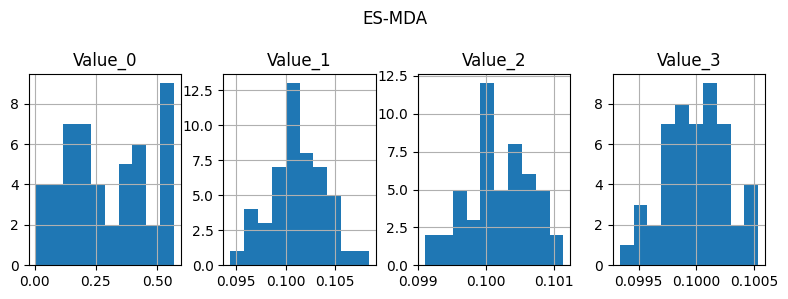

In [29]:
fig, ax = plt.subplots(1, len(normalized_weights) + 1)
fig.suptitle("ES-MDA")
fig.set_size_inches(8, 3)
df_ESMDA_pivot.hist(ax=ax)
fig.tight_layout()

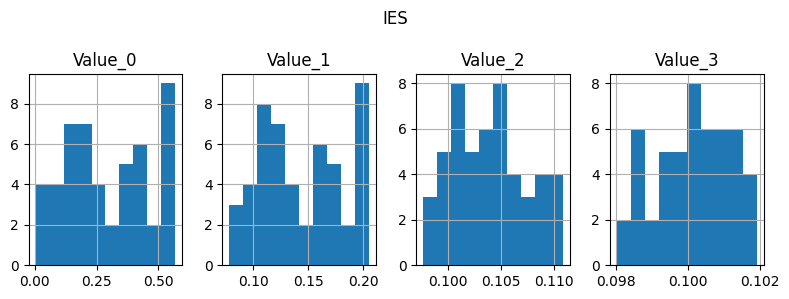

In [30]:
fig, ax = plt.subplots(1, number_of_ies_iterations + 1)
fig.suptitle("IES")
fig.set_size_inches(8, 3)
df_IES_pivot.hist(ax=ax)
fig.tight_layout()